In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
import scipy.stats as stats

# Initial Data Cleaning

In [2]:
movie_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
movie_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')
reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', encoding='ANSI')
movies = pd.read_csv('zippedData/tmdb.movies.csv.gz')
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

In [3]:
import zipfile
zip_file = "zippedData/im.db.zip"
try:
    with zipfile.ZipFile(zip_file, 'r') as z:
        z.extractall("zippedData/unZippedim.db")
        print("Extracted all")
except:
    print("Invalid file")

conn = sqlite3.connect("zippedData/unZippedim.db/im.db")

Extracted all


In [4]:
movie_gross['foreign_gross'] = movie_gross['foreign_gross'].str.replace(',','')
movie_gross['foreign_gross'] = movie_gross["foreign_gross"].astype("float64")

movie_info['runtime'] = movie_info['runtime'].str.replace(' minutes','')
movie_info['runtime']  = movie_info['runtime'].astype("float64")
movie_info['box_office'] = movie_info['box_office'].str.replace(',','')
movie_info['box_office'] = movie_info['box_office'].astype("float64")

movie_budgets['production_budget'] = movie_budgets['production_budget'].str.replace(',','')
movie_budgets['production_budget'] = movie_budgets['production_budget'].str.replace('$', '')
movie_budgets['production_budget'] = movie_budgets['production_budget'].astype("float64")
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].str.replace(',','')
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].str.replace('$', '')
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].astype("float64")
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].str.replace(',','')
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].str.replace('$', '')
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].astype("float64")

# Cleaning Review Ratings from Rotten Tomatoes
A brief analysis will reveal that ratings within the Rotten Tomatoes reviews database are very inconsistent. We seek to clean and reorganize these ratings to make them usable.

In [5]:
reviews.drop_duplicates(inplace=True)

In [6]:
reviews['rating'].unique()

array(['3/5', nan, 'C', '2/5', 'B-', '2/4', 'B', '3/4', '4/5', '4/4',
       '6/10', '1/4', '8', '2.5/4', '4/10', '2.0/5', '3/10', '7/10', 'A-',
       '5/5', 'F', '3.5/4', 'D+', '1.5/4', '3.5/5', '8/10', 'B+', '9/10',
       '2.5/5', '7.5/10', '5.5/10', 'C-', '1.5/5', '1/5', '5/10', 'C+',
       '0/5', '6', '0.5/4', 'D', '3.1/5', '3/6', '4.5/5', '0/4', '2/10',
       'D-', '7', '1/10', '3', 'A+', 'A', '4.0/4', '9.5/10', '2.5',
       '2.1/2', '6.5/10', '3.7/5', '8.4/10', '9', '1', '7.2/10', '2.2/5',
       '0.5/10', '5', '0', '2', '4.5', '7.7', '5.0/5', '8.5/10', '3.0/5',
       '0.5/5', '1.5/10', '3.0/4', '2.3/10', '4.5/10', '4/6', '3.5',
       '8.6/10', '6/8', '2.0/4', '2.7', '4.2/10', '5.8', '4', '7.1/10',
       '5/4', 'N', '3.5/10', '5.8/10', 'R', '4.0/5', '0/10', '5.0/10',
       '5.9/10', '2.4/5', '1.9/5', '4.9', '7.4/10', '1.5', '2.3/4',
       '8.8/10', '4.0/10', '2.2', '3.8/10', '6.8/10', '7.3', '7.0/10',
       '3.2', '4.2', '8.4', '5.5/5', '6.3/10', '7.6/10', '8.1/10',
  

## Approach

We will clean the ratings column, split it into two new columns "num_of_stars" and "out_of_stars", and create a third column 'rating_out_of_10' yielding the equivalent number of stars out of 10.

We will make the following modifications to the ratings column:
- We will be changing all letter "grades" to numerical scores out of 10, evenly distributed between 0 and 10.
    - Note that F+ and F- will be grouped with F.
- We will be replacing all NaN ratings, ratings out of 2, all ratings without an "out-of" denominator, and any other nonsensical ratings with '-1/1'. This will allow us to split all ratings by the '/' character before calculating ratings out of 10; upon creating the new columns we will go back and reset all '-1/1' values to NaN.

### Cleaning the Ratings

In [7]:
import numpy as np

# Change letter ratings to numerical (out of 10)
reviews['rating'].replace('F+', 'F', inplace=True)
reviews['rating'].replace('F-', 'F', inplace=True)

letter_ratings = ['A+','A','A-','B+','B','B-','C+','C','C-','D+','D','D-','F']
nums = list(np.round(np.linspace(0,10, 13), 1))
num_ratings = [f'{str(num)}/10' for num in nums]
mapping = dict(zip(letter_ratings, num_ratings))

for rating in letter_ratings:
    reviews.replace(rating, mapping[rating], inplace=True)

reviews['rating'].fillna('-1/1', inplace=True)
    
# # Remove all ratings that do not contain '/'
for rating in reviews['rating'].unique():
    if "/" not in rating:
        reviews['rating'].replace(rating, '-1/1', inplace=True)

# Remove other nonsensical ratings
reviews['rating'].replace('R', '-1/1', inplace=True)
reviews['rating'].replace('N', '-1/1', inplace=True)
reviews['rating'].replace('T', '-1/1', inplace=True)

reviews['rating'].replace('1/2', '-1/1', inplace=True)
reviews['rating'].replace('2/2', '-1/1', inplace=True)
reviews['rating'].replace('3/2', '-1/1', inplace=True)
reviews['rating'].replace('3 1/2', '-1/1', inplace=True)
reviews['rating'].replace('1-5', '-1/1', inplace=True)
reviews['rating'].replace('5/4', '-1/1', inplace=True)
reviews['rating'].replace('2.1/2', '-1/1', inplace=True)
reviews['rating'].replace('5.5/5', '-1/1', inplace=True)



In [8]:
reviews['rating'].unique()

array(['3/5', '-1/1', '5.8/10', '2/5', '4.2/10', '2/4', '3.3/10', '3/4',
       '4/5', '4/4', '6/10', '1/4', '2.5/4', '4/10', '2.0/5', '3/10',
       '7/10', '1.7/10', '5/5', '10.0/10', '3.5/4', '7.5/10', '1.5/4',
       '3.5/5', '8/10', '2.5/10', '9/10', '2.5/5', '5.5/10', '6.7/10',
       '1.5/5', '1/5', '5/10', '5.0/10', '0/5', '0.5/4', '8.3/10',
       '3.1/5', '3/6', '4.5/5', '0/4', '2/10', '9.2/10', '1/10', '0.0/10',
       '0.8/10', '4.0/4', '9.5/10', '6.5/10', '3.7/5', '8.4/10', '7.2/10',
       '2.2/5', '0.5/10', '5.0/5', '8.5/10', '3.0/5', '0.5/5', '1.5/10',
       '3.0/4', '2.3/10', '4.5/10', '4/6', '8.6/10', '6/8', '2.0/4',
       '7.1/10', '3.5/10', '4.0/5', '0/10', '5.9/10', '2.4/5', '1.9/5',
       '7.4/10', '2.3/4', '8.8/10', '4.0/10', '3.8/10', '6.8/10',
       '7.0/10', '6.3/10', '7.6/10', '8.1/10', '3.6/5', '2/6', '7.7/10',
       '8.9/10', '8.2/10', '2.6/6', '4.1/10', '6.0/10', '1.0/4', '7.9/10',
       '8.7/10', '4.3/10', '9.6/10', '9.0/10', '8.0/10', '6.2/10', '1/

### Creating New Columns

In [9]:
reviews['num_stars'] = reviews['rating'].map(lambda x : float(x.split('/')[0]))
reviews['out_of_stars'] = reviews['rating'].map(lambda x : float(x.split('/')[1]))
reviews['rating_out_of_10'] = reviews['num_stars'] / reviews['out_of_stars'] * 10
reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date,num_stars,out_of_stars,rating_out_of_10
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018",3.0,5.0,6.0
1,3,It's an allegory in search of a meaning that n...,-1/1,rotten,Annalee Newitz,0,io9.com,"May 23, 2018",-1.0,1.0,-10.0
2,3,... life lived in a bubble in financial dealin...,-1/1,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018",-1.0,1.0,-10.0
3,3,Continuing along a line introduced in last yea...,-1/1,fresh,Daniel Kasman,0,MUBI,"November 16, 2017",-1.0,1.0,-10.0
4,3,... a perverse twist on neorealism...,-1/1,fresh,NaN,0,Cinema Scope,"October 12, 2017",-1.0,1.0,-10.0


In [10]:
reviews['rating'].replace('-1/1', np.nan, inplace=True)
reviews['num_stars'].replace(-1.0, np.nan, inplace=True)
reviews['out_of_stars'].replace(1.0, np.nan, inplace=True)
reviews['rating_out_of_10'].replace(-10.0, np.nan, inplace=True)

# Exploratory Data Analysis on Rotten Tomatoes Reviews

In [11]:
reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date,num_stars,out_of_stars,rating_out_of_10
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018",3.0,5.0,6.0
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018",NaN,NaN,NaN
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018",NaN,NaN,NaN
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017",NaN,NaN,NaN
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017",NaN,NaN,NaN


In [12]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54423 entries, 0 to 54431
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                54423 non-null  int64  
 1   review            48867 non-null  object 
 2   rating            40129 non-null  object 
 3   fresh             54423 non-null  object 
 4   critic            51710 non-null  object 
 5   top_critic        54423 non-null  int64  
 6   publisher         54114 non-null  object 
 7   date              54423 non-null  object 
 8   num_stars         40129 non-null  float64
 9   out_of_stars      40129 non-null  float64
 10  rating_out_of_10  40129 non-null  float64
dtypes: float64(3), int64(2), object(6)
memory usage: 5.0+ MB


In [13]:
reviews.loc[reviews['rating'].isna() == False].head()

,id,review,rating,fresh,critic,top_critic,publisher,date,num_stars,out_of_stars,rating_out_of_10
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018",3.0,5.0,6.0
6,3,"Quickly grows repetitive and tiresome, meander...",5.8/10,rotten,Eric D. Snider,0,EricDSnider.com,"July 17, 2013",5.8,10.0,5.8
7,3,Cronenberg is not a director to be daunted by ...,2/5,rotten,Matt Kelemen,0,Las Vegas CityLife,"April 21, 2013",2.0,5.0,4.0
11,3,"While not one of Cronenberg's stronger films, ...",4.2/10,fresh,Emanuel Levy,0,EmanuelLevy.Com,"February 3, 2013",4.2,10.0,4.2
12,3,Robert Pattinson works mighty hard to make Cos...,2/4,rotten,Christian Toto,0,Big Hollywood,"January 15, 2013",2.0,4.0,5.0


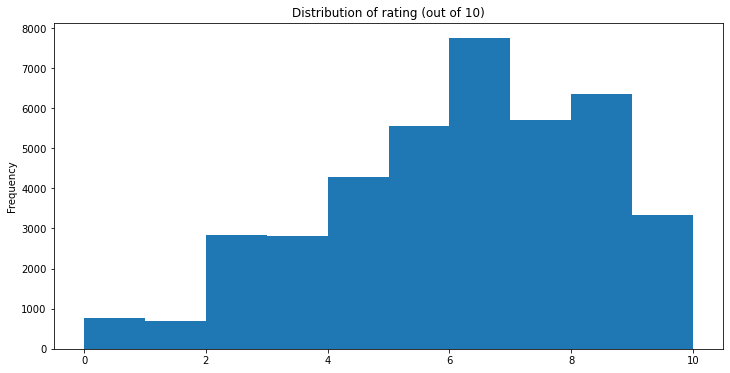

In [14]:
reviews['rating_out_of_10'].plot(figsize=(12,6), kind='hist', title='Distribution of rating (out of 10)');

In [15]:
reviews['rating_out_of_10'].mean()

5.91708490119365

In [16]:
reviews['rating_out_of_10'].median()

6.0

In [17]:
reviews['rating_out_of_10'].mode()

0    6.0
dtype: float64

In [18]:
reviews.groupby('fresh')['id'].count()

fresh
fresh     33032
rotten    21391
Name: id, dtype: int64

We have found that movies average **6 out of 10 stars**. We could consider movies with below 6 out of 10 stars to be below average and movies with above 6 out of 10 stars to be above average.

# Research Question
Do a **director's previous movie ratings** relate to the **profit** that their movies generate?

## Approach
To answer this question, we will begin by creating two groups of directors - those with a "good" average rating, and those with a "bad" average rating. We will determine a threshold by which we can classify ratings as "good" or "bad" by investigating the distribution of Rotten Tomatoes rating data within movies classified by Rotten Tomatoes as "fresh" and those classified as "rotten", as well as considering the results from the exploratory data analysis performed above.

Upon choosing a threshold, we will use IMDB databases joined with movie budget data from The Numbers to calculate mean movie rating by director along with the director's mean profit. In particular, we are interested in established directors - those who have received over 1,000 reviews and have worked on at least two movies. We will then split these directors into two groups - one group with mean ratings of greater than or equal to the threshold, and one with mean ratings below the threshold.

We will then investigate whether there is a relationship between mean rating by director and their mean profit. We will conduct a hypothesis test to determine if the mean profit for established directors with the higher mean ratings is greater than that of established directors with the lower mean ratings.

### Determining a Threshold

In [19]:
rotten_tomatoes = movie_info.merge(reviews, on='id')

In [20]:
rotten_tomatoes.head()

,id,synopsis,rating_x,genre,director,writer,theater_date,dvd_date,currency,box_office,...,review,rating_y,fresh,critic,top_critic,publisher,date,num_stars,out_of_stars,rating_out_of_10
0,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,...,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018",3.0,5.0,6.0
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,...,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018",NaN,NaN,NaN
2,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,...,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018",NaN,NaN,NaN
3,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,...,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017",NaN,NaN,NaN
4,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,...,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017",NaN,NaN,NaN


In [21]:
fresh_reviews = rotten_tomatoes.loc[rotten_tomatoes['fresh'] == 'fresh']
rotten_reviews = rotten_tomatoes.loc[rotten_tomatoes['fresh'] == 'rotten']

C:\Users\nnetznik\Anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\nnetznik\Anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


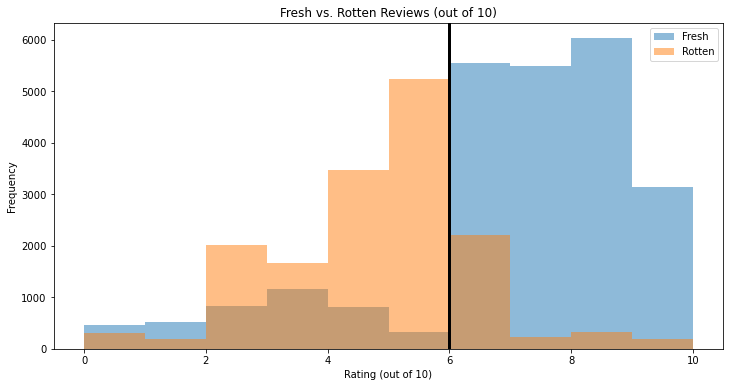

In [22]:
fig, ax = plt.subplots(figsize=(12,6))
ax.hist(fresh_reviews['rating_out_of_10'], alpha=0.5)
ax.hist(rotten_reviews['rating_out_of_10'], alpha=0.5)
ax.set_title("Fresh vs. Rotten Reviews (out of 10)")
ax.set_xlabel("Rating (out of 10)")
ax.set_ylabel("Frequency")
ax.legend(['Fresh','Rotten'])
plt.axvline(x=6, color='black', lw=3);

Based upon the visualization above, as well as the distribution of ratings investigated in the preceding exploratory data analysis on Rotten Tomatoes reviews, we will set our threshold to **6 out of 10**.

### Gathering Data

In [23]:
movie_budgets['profit'] = movie_budgets['worldwide_gross']-movie_budgets['production_budget']

In [ ]:
directorRatings = pd.read_sql("""
    SELECT 
    persons.primary_name AS director, movie_basics.original_title AS title, movie_ratings.averagerating AS AVG_Movie_rating
    FROM persons
    JOIN principals
        USING(person_id)
    JOIN movie_basics
        USING(movie_id)
    JOIN movie_ratings
        USING(movie_id)
    GROUP BY persons.primary_name
    HAVING principals.category == 'director' AND movie_ratings.numvotes >= 1000 AND COUNT(movie_ratings.movie_id) > 1
    ORDER BY AVG_Movie_rating DESC
  ;
""", conn)

In [ ]:
directorRatings.head()

In [ ]:
budgetJoinDirector = movie_budgets.merge(directorRatings, left_on = 'movie', right_on='title')

In [ ]:
budgetJoinDirector.head()

To obtain relevant data, we will only focus on data between **2010 and 2017**:

In [ ]:
budgetJoinDirector['year'] = budgetJoinDirector['release_date'].map(lambda x : x[-4:]).astype(int)
budgetJoinDirector.head()

In [ ]:
budgetJoinDirector = budgetJoinDirector.loc[(budgetJoinDirector['year'] >= 2010) & (budgetJoinDirector['year'] <= 2017)]

In [ ]:
budgetJoinDirector['year'].unique()

In [ ]:
budgetJoinDirector.info()

We adjust our budget and worldwide gross data for **inflation**:

In [ ]:
i = 0
for row in budgetJoinDirector.itertuples(index = False):
    if row[10] == 2010:
        budgetJoinDirector.iat[i,3] = row[3] * ((8*.0151) + 1)
       
    if row[10] == 2011:
        budgetJoinDirector.iat[i,3] = row[3] * ((7*.0151) + 1)
        
    if row[10] == 2012:
        budgetJoinDirector.iat[i,3] = row[3] * ((6*.0151) + 1)
       
    if row[10] == 2013:
        budgetJoinDirector.iat[i,3] = row[3] * ((5*.0151) + 1)
        
    if row[10] == 2014:
        budgetJoinDirector.iat[i,3] = row[3] * ((4*.0151) + 1)
        
    if row[10] == 2015:
        budgetJoinDirector.iat[i,3] = row[3] * ((3*.0151) + 1)
        
    if row[10] == 2016:
        budgetJoinDirector.iat[i,3] = row[3] * ((2*.0151) + 1)
        
    if row[10] == 2017:
        budgetJoinDirector.iat[i,3] = row[3] * ((1*.0151) + 1)
       
    i +=1
    

In [ ]:
i = 0
for row in budgetJoinDirector.itertuples(index = False):
    if row[10] == 2010:
        budgetJoinDirector.iat[i,5] = row[5] * ((8*.0451) + 1)
       
    if row[10] == 2011:
        budgetJoinDirector.iat[i,5] = row[5] * ((7*.0451) + 1)
        
    if row[10] == 2012:
        budgetJoinDirector.iat[i,5] = row[5] * ((6*.0451) + 1)
       
    if row[10] == 2013:
        budgetJoinDirector.iat[i,5] = row[5] * ((5*.0451) + 1)
        
    if row[10] == 2014:
        budgetJoinDirector.iat[i,5] = row[5] * ((4*.0451) + 1)
        
    if row[10] == 2015:
        budgetJoinDirector.iat[i,5] = row[5] * ((3*.0451) + 1)
        
    if row[10] == 2016:
        budgetJoinDirector.iat[i,5] = row[5] * ((2*.0451) + 1)
        
    if row[10] == 2017:
        budgetJoinDirector.iat[i,5] = row[5] * ((1*.0451) + 1)
       
    i +=1

In [ ]:
budgetJoinDirector=budgetJoinDirector.drop('id', axis =1)
budgetJoinDirector=budgetJoinDirector.drop('release_date', axis =1)
budgetJoinDirector=budgetJoinDirector.drop('title', axis =1)


In [ ]:
budgetJoinDirector['profit'] = budgetJoinDirector['worldwide_gross']-budgetJoinDirector['production_budget']

In [ ]:
budgetJoinDirector.groupby('director').mean().sort_values('AVG_Movie_rating', ascending = False)

In [ ]:
budgetJoinDirector['positive_review'] = budgetJoinDirector['AVG_Movie_rating'] >= 6

In [ ]:
grouped = budgetJoinDirector.groupby('director').mean().sort_values('AVG_Movie_rating', ascending = False)

In [ ]:
greaterThanEqual6 = grouped.loc[grouped['AVG_Movie_rating'] >= 6]['profit']

In [ ]:
lessThan6 = grouped.loc[grouped['AVG_Movie_rating'] < 6]['profit']

### Investigating Data

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
sns.regplot(grouped['AVG_Movie_rating'], grouped["profit"])
ax.set_title('Regression Plot: mean rating vs. mean profit')
ax.set_xlabel('Mean movie rating by director')
ax.set_ylabel('Mean profit by director')

In [ ]:
np.corrcoef(grouped['AVG_Movie_rating'], grouped['profit'])[0][1]

In [ ]:
print(len(greaterThanEqual6))
print(len(lessThan6))

In [ ]:
greaterThanEqual6.mean()

In [ ]:
lessThan6.mean()

In [ ]:
greaterThanEqual6.median()

In [ ]:
lessThan6.median()

In [ ]:
greaterThanEqual6.std()

In [ ]:
lessThan6.std()

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(greaterThanEqual6)
ax.set_title('Boxplot of mean profit by director, mean rating >= 6')
ax.set_xlabel('Mean profit by director, mean rating >= 6');

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(lessThan6)
ax.set_title('Boxplot of mean profit by director, mean rating < 6')
ax.set_xlabel('Mean profit by director, mean rating < 6');

It appears that our data contains several outliers. We will trim these outliers using the **IQR rule** before proceeding with our analysis.

### Trimming Outliers

In [ ]:
Q1 = grouped['profit'].quantile(0.25)
Q3 = grouped['profit'].quantile(0.75)
IQR = Q3-Q1
grouped_trimmed = grouped.loc[(grouped['profit'] >= Q1-1.5*IQR) & (grouped['profit'] <= Q3 + 1.5*IQR)]

In [ ]:
len(grouped_trimmed)

In [ ]:
greaterThanEqual6_trimmed = grouped_trimmed.loc[grouped_trimmed['AVG_Movie_rating'] >= 6]['profit']
lessThan6_trimmed = grouped_trimmed.loc[grouped_trimmed['AVG_Movie_rating'] < 6]['profit']

In [ ]:
plt.figure(figsize=(12,6))
g = sns.regplot(grouped_trimmed['AVG_Movie_rating'], grouped_trimmed["profit"])
g.axvline(6, color='red', lw=3, alpha=0.5);

In [ ]:
np.corrcoef(grouped_trimmed['AVG_Movie_rating'], grouped_trimmed['profit'])[0][1]

In [ ]:
greaterThanEqual6_trimmed.mean()

In [ ]:
lessThan6_trimmed.mean()

In [ ]:
greaterThanEqual6_trimmed.mean() - lessThan6_trimmed.mean()

In [ ]:
greaterThanEqual6_trimmed.std(ddof=1)**2

In [ ]:
lessThan6_trimmed.std(ddof=1)**2

#### Observations
* There is a **slight positive correlation** between average movie rating per director and profit.

* The means of these two categories **differ**.
* The variances of these two categories **differ**.

## Rationale and Analysis

Using $\alpha=0.05$, we will conduct a one-tailed unpaired Welch's t-test (which does NOT assume that population variances are equal) to test our hypothesis that established directors with a mean rating of greater than or equal to 6 produce a greater mean profit than those with a mean rating of less than 6.

Let:
> $\mu_{GE6}$ denote the mean profit for directors with a mean rating of greater than or equal to 6;

> $\mu_{L6}$ denote the mean profit for directors with a mean rating of less than 6.

$H_{0}: \mu_{GE6} - \mu_{L6} = 0$

$H_{A}: \mu_{GE6} - \mu_{L6} > 0$

In [ ]:
statistic, pvalue = stats.ttest_ind(greaterThanEqual6_trimmed, lessThan6_trimmed, equal_var=False)
pvalue/2

### Limitations
Given our choice of alpha, there is a 5% probability of rejecting the null hypothesis when it is actually true.

### Conclusion
If both groups do produce the same profits, there is approximately a 0.19% chance that we obtain a difference in sample means at least as large as obtained above. Given this probability and $\alpha=0.05$, we conclude that established directors with a mean rating of greater than or equal to 6 produce **greater mean profits** than those with a mean rating of less than 6.

## Recommendation
We recommend that ...